# YoloF - Pytorch
This notebook shows how to compile YoloF/Pytorch to AWS Inferentia (inf1 instances) using NeuronSDK. We'll use pre-trained models (Coco) provided by the author.

**Reference:** https://github.com/chensnathan/YOLOF

## 1) Install dependencies

In [ ]:
# Set Pip repository  to point to the Neuron repository
%pip config set global.extra-index-url https://pip.repos.neuron.amazonaws.com
# now restart the kernel

In [ ]:
#Install Neuron PyTorch
%pip install -U torch-neuron==1.10.1.2.2.0.0 neuron-cc[tensorflow] "protobuf<4" numpy==1.19.5
# use --force-reinstall if you're facing some issues while loading the modules
# this particular version of numpy is required to avoid issues during compilation
# now restart the kernel again

In [ ]:
import torch
assert(torch.__version__.startswith("1.10.1"))

### 1.1) Install Detectron2
-> The following version is required to make YoloF work

In [ ]:
# source: https://detectron2.readthedocs.io/en/latest/tutorials/install.html
%pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html

### 1.2) Download pre-trained weights

In [ ]:
!curl -v -o YOLOF_R50_C5_1x.pth \
    -H "User-Agent: oneleaf" \
    "https://bjbgp01.baidupcs.com/file/fd530f25fgd5e71bfe3172edcba42284?bkt=en-cf7b18a7c51d90784d4721e079660bd1c508d1a59c26db95191fbd5338974fe69413e79c3a85ea43&fid=1102788638000-250528-443184714452584&time=1661444587&sign=FDTAXUbGERLQlBHSKfWaqi-DCb740ccc5511e5e8fedcff06b081203-baKqzFLn%2BAAdeKV2GaryDI6a%2FDI%3D&to=14&size=355751010&sta_dx=355751010&sta_cs=0&sta_ft=pth&sta_ct=7&sta_mt=0&fm2=MH%2CXian%2CAnywhere%2C%2Cdefault%2Cany&ctime=1616077993&mtime=1661444585&resv0=-1&resv1=0&resv2=rlim&resv3=5&resv4=355751010&vuk=1102788638000&iv=0&htype=&randtype=&tkbind_id=0&newver=1&newfm=1&secfm=1&flow_ver=3&pkey=en-872dc5a00fb9844e3b376b514ab78bd5b35e26868b36eb253e759d554691da7e0793a0c76d8659d4&sl=76480590&expires=8h&rt=pr&r=232104072&vbdid=-&fin=YOLOF_R50_DC5_1x.pth&rtype=1&dp-logid=2239089140189580187&dp-callid=0.1&tsl=80&csl=80&fsl=-1&csign=CdXMJiWg0JmC2HWrV85via4TPTA%3D&so=1&ut=6&uter=0&serv=0&uc=1684384414&ti=3dbf888e013f65631284a50cdcb79b9ccccaa9ac32e26294&hflag=30&from_type=3&adg=c_bcbbd4556ba8a0393270a2320bcb8d35&reqlabel=250528_f_9640d06a9a72bbf5757be9dd14e15fd2_-1_19d1cb48e684be760b8b59fa96a038f5&by=themis"

### 1.3) Clone the official YoloF Repo

In [ ]:
!rm -rf YOLOF && git clone https://github.com/chensnathan/YOLOF && \
    cd YOLOF && \
    git checkout a44b7af0efa9b89d3e91db70bc9a39e49d5d0144

### 1.4) Prepare and apply a patch that bypasses the detection layer
This workaround is required to avoid issues with the compiler. We'll rebuild the model later after compiling it.

In [ ]:
%%writefile no_detection.patch
diff --git a/yolof/modeling/yolof.py b/yolof/modeling/yolof.py
index 861828b..51ce521 100644
--- a/yolof/modeling/yolof.py
+++ b/yolof/modeling/yolof.py
@@ -305,6 +305,7 @@ class YOLOF(nn.Module):
 
             return losses
         else:
+            return torch.cat([torch.cat([b.unsqueeze(0) for b in i],0) for i in anchors_image], 0),torch.cat([i.unsqueeze(0) for i in pred_logits], 0),torch.cat([i.unsqueeze(0) for i in pred_anchor_deltas], 0)
             results = self.inference(
                 anchors_image,
                 pred_logits,

In [ ]:
!cd YOLOF && git apply ../no_detection.patch

## 2) Initialize libraries and prepare input samples

In [ ]:
import sys
if not 'YOLOF' in sys.path: sys.path.append('YOLOF')
import os
import torch
from yolof.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file('YOLOF/configs/yolof_R_50_C5_1x.yaml')
cfg.MODEL.WEIGHTS='YOLOF_R50_C5_1x.pth'
cfg.MODEL.DEVICE='cpu'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.freeze()

## Be careful with the input shape size. 
## 300x300 is close to the memory limit of a inf1.x6large. If you increase it you will need a biger machine
image = torch.rand(3,300,300).float()
inp = [{'image': image}]

## 3) Load a pre-trained model and check if it is .jit traceable

The original detectron2 model is not .jit traceable. However, the framework provides a helper class called **TracingAdapter**. Let's use this adapter to make our model traceble

In [ ]:
from detectron2.export import TracingAdapter
from detectron2.engine import DefaultPredictor

predictor = DefaultPredictor(cfg)
model = predictor.model

y = model(inp)

adapter = TracingAdapter(model, inp)

try:
    # can now trace the model, with adapter.flattened_inputs, or another
    # tuple of tensors with the same length and meaning
    traced = torch.jit.trace(adapter, adapter.flattened_inputs)
    print("Cool! Model is jit traceable")
except Exception as e:
    print("Ops. Something went wrong. Model is not traceable")

## ok the model is .jit traceable. now let's compile it with NeuronSDK
# traced model can only produce flattened outputs (tuple of tensors)
flattened_outputs = traced(*adapter.flattened_inputs)
# adapter knows the schema to convert it back (new_outputs == outputs)
new_outputs = adapter.outputs_schema(flattened_outputs)

## 4) Analyze & compile the model for Inferentia with NeuronSDK

Neuron Check Model tool provides user with basic information about the compiled and uncompiled model’s operations without the use of TensorBoard-Neuron.  
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-tools/tutorial-neuron-check-model.html


The PyTorch-Neuron trace Python API provides a method to generate PyTorch models for execution on Inferentia, which can be serialized as TorchScript. It is analogous to torch.jit.trace() function in PyTorch.   
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-compilation-python-api.html?highlight=trace

In [ ]:
import torch
import torch.neuron
torch.neuron.analyze_model(adapter, example_inputs=adapter.flattened_inputs)

In [ ]:
import torch
import torch.neuron
neuron_model = torch.neuron.trace(adapter, adapter.flattened_inputs)
neuron_model.save('yolof_neuron.pt')

### 4.1) Verify the optimized model

In [ ]:
y = neuron_model(*adapter.flattened_inputs) # warmup
%timeit neuron_model(*adapter.flattened_inputs)

## 5) Rebuild the forward and add back post-processing
The patch we applied at the beginning of this notebook removed the post-processing functions from the last layer. Now we need to add them back to the model before using it.

In [ ]:
import types
import torch
import torch.neuron
from detectron2.structures import Boxes
from detectron2.modeling.postprocessing import detector_postprocess

# load a new & fresh model
predictor = DefaultPredictor(cfg)
model = predictor.model
model.eval()

## now let's put everything togeter
def fwd(self, x):
    image_sizes = [tuple(x.shape[-2:])]
    anchors_image,pred_logits,pred_anchor_deltas = self.model_neuron(x)
    results = self.inference(
        [Boxes(anchors_image)],
        pred_logits,
        pred_anchor_deltas,
        image_sizes
    )
    processed_results = []
    for results_per_image, input_per_image, image_size in zip(
            results, x, image_sizes
    ):
        height = image_size[0]
        width = image_size[1]
        r = detector_postprocess(results_per_image, height, width)
        processed_results.append({"instances": r})
    return processed_results

if not hasattr(model, 'forward_'): model.forward_ = model.forward
model.forward = types.MethodType(fwd, model)
model.model_neuron = torch.jit.load('yolof_neuron.pt')

## 6) A simple test to check the predictions

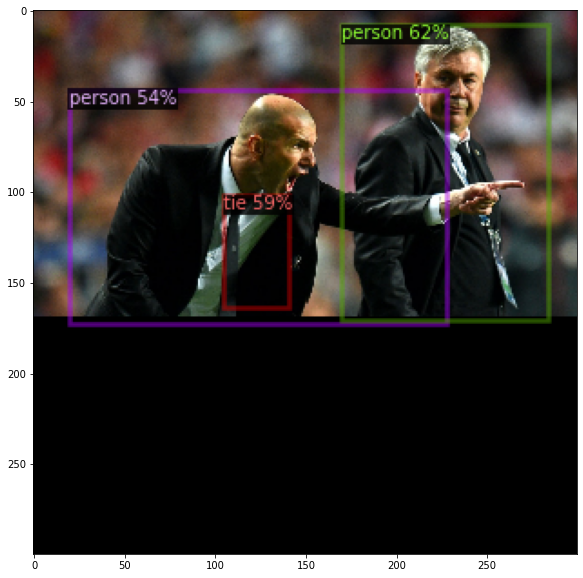

In [21]:
%matplotlib inline
if '..' not in sys.path: sys.path.append('..')
import matplotlib.pyplot as plt
import cv2
import numpy as np

from common import processing

from detectron2.utils.visualizer import Visualizer, VisImage, _create_text_labels
from detectron2.data import MetadataCatalog
from detectron2.structures import Instances

# load a sample image
img = processing.load_sample_imgB()
h,w,c = img.shape
if h!=w:
    max_side=max(h,w)
    new_img = np.zeros((max_side,max_side,c), dtype=np.uint8)
    new_img[0:h, 0:w] = img[:]
    img = new_img
img = cv2.resize(img, (300,300))
x = torch.as_tensor(img.astype("float32").transpose(2, 0, 1))

predictions = model(x)[0]['instances']

boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
scores = predictions.scores if predictions.has("scores") else None
classes = predictions.pred_classes if predictions.has("pred_classes") else None

indices = np.where(scores > 0.54)
boxes = boxes[indices] 
classes = classes[indices] 
scores = scores[indices]

v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
labels = _create_text_labels(classes, scores, v.metadata.get("thing_classes", None))
result = v.overlay_instances(boxes=boxes,labels=labels)
result_image = result.get_image()[:, :, ::-1]

result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(result_image)